<a href="https://colab.research.google.com/github/chandanadasarii/AnomalyDetection_IOT/blob/master/AnomalyDetection_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

####Reading the files from GDrive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#### Importing the necessary libraries

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from datetime import datetime
import missingno as msno
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import matplotlib
import glob
files= glob.glob("/content/drive/My Drive/AnomalyDetection/Sensordata2/*.csv")
print(files)

['/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT 1st Floor-Insight Museum Hall-CO2.csv', '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT 1st Floor-Insight Museum Hall-Humidity.csv', '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT 1st Floor-Insight Museum Hall-Noise.csv', '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT 1st Floor-Insight Museum Hall-Temperature.csv', '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT 1st Floor-Insight Museum Hall-Pressure.csv', '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT 2nd Floor-Insight-OpenIoT Kitchen-Humidity.csv', '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT 2nd Floor-Insight-OpenIoT Kitchen-CO2.csv', '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT 1st Floor-Insight Outdoor-Temperature.csv', '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT 1st Floor-In

In [0]:
# def main():
'''
preprocessing the sensor data given in .csv format
total sensors = 24
Steps :
1. Formatting the data to make it into standard form wrt to time.
Therefore each entry can be identified with a single value of ddmmyytttt
and saved the result into full_data.csv after processing the time
'''
print("INFO : STEP 1")
full_data = pd.DataFrame(columns=['time', 'dummy'])

# files contains list of all files
for file in files:
    data = pd.read_csv(file)
    sensor_dataframe = pd.DataFrame(data)
    # print(sensor_dataframe)
    # Creating different data frame with the name of the sensor file file[:-4] to remove the .csv from the column name
    # each data frame has time column, and corresponding sensor column
    sensor_dataframe.columns = ['time', file[:-4]]
    # Converting the time column to datetime format
    sensor_dataframe['time'] = pd.to_datetime(sensor_dataframe['time'])
    #formatting the time
    sensor_dataframe['time'] = sensor_dataframe.time.dt.strftime('%y%m%d%H%M')

    # merging all the sensor data frames based on the time column
    full_data = pd.merge(full_data, sensor_dataframe, on='time', how='outer')

#dropping the dummy column
full_data=full_data.drop(columns='dummy')
print("INFO : all sensors data merged into single dataframe Successful...")

#######################################################################################

'''
Preprocessing 2:
This file reads the full_data generated by preprocessing_data.py
This file contains the code for Unifying the all variables data to standard interval of 15 min window.
and saving it to the Data_grouping.csv
'''

print("INFO : STEP 2 ")

def transform(time):
    time = str(time)
    if int(time[-2:]) < 15:
        time = time[:-2] + '00'
    elif int(time[-2:]) < 30:
        time = time[:-2] + '15'
    elif int(time[-2:]) < 45:
        time = time[:-2] + '30'
    else:
        time = time[:-2] + '45'
    return int(time)

full_data['time'] = full_data['time'].apply(transform)
# at any point of time i have only 1 value so mean doesnot effect the data
FD_g = full_data.groupby(['time']).mean()
print("INFO : All the sensors times rounded off to 15:30:45:00 min")
print("INFO : Final DataFrame Size after merging : " , FD_g.shape)
FD_g['time'] = FD_g.index
# Resetting the index
FD_g.reset_index(drop=True, inplace=True)
FD_g['time'] = pd.to_datetime(FD_g['time'],format='%y%m%d%H%M')
# datetime_try = datetime.strptime()
print("INFO : Adding new columns : month, day, hour, minute")
FD_g['month'] = FD_g.time.dt.strftime('%m')
FD_g['day'] = FD_g.time.dt.strftime('%d')
FD_g['hour'] = FD_g.time.dt.strftime('%h')
FD_g['minute'] = FD_g.time.dt.strftime('%M')
FD_g['utime'] = FD_g.time.dt.strftime('%y%m%d%H%M')


print("INFO : Final DataFrame Size after addition of new columns : " , FD_g.shape)
'''
There are so many missing values present in the dataset because of the connection failure , power failure and for other reasons
To successfully model the data and get meaningful insights. Handling the missing data plays a vital role as well.
'''

'''
Need to create some efficient mechanism for handling the missing values
Impute missing values think of an efficient way
https://machinelearningmastery.com/handle-missing-data-python/
'''
print("INFO : removing the missing values")    
Data = FD_g.dropna(how='any')  
print("INFO : after dropping na", Data.shape)

# This gives the counts of values
for column in Data.columns:
    if Data[column].isnull().sum()>0:
        sensor_values = Data[column].value_counts(dropna=False)
        s = pd.DataFrame(sensor_values)
        # getting second highest value - first highest would be - NaN second
        # highest - most common value; using this value to fill NaN doesnt effect much
        tobe_filled_value = s.index.tolist()
        # print(tobe_filled_value[1])
        Data[column].fillna(value = tobe_filled_value[2],inplace=True)
        # sensor_values = Data['Insight-OpenIoT 1st Floor-Insight Museum Hall-CO2'].value_counts(dropna=False)
print('INFO : PREPROCESSING STEP 3  IS DONE')
Data.reset_index(drop=True, inplace=True)



# if __name__ == '__main__':
#     print('Preprocessing Data')
#     main()

INFO : STEP 1
INFO : all sensors data merged into single dataframe Successful...
INFO : STEP 2 
INFO : All the sensors times rounded off to 15:30:45:00 min
INFO : Final DataFrame Size after merging :  (9282, 24)
INFO : Adding new columns : month, day, hour, minute
INFO : Final DataFrame Size after addition of new columns :  (9282, 30)
INFO : removing the missing values
INFO : after dropping na (2652, 30)
INFO : PREPROCESSING STEP 3  IS DONE


####Map the column names 

In [0]:
Data.rename(columns={'/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT 1st Floor-Insight Museum Hall-CO2':'ff_museum_c02',
                     '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT 1st Floor-Insight Museum Hall-Humidity': 'ff_museum_Humidity',
                     '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT 1st Floor-Insight Museum Hall-Noise': 'ff_museum_noise',
       '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT 1st Floor-Insight Museum Hall-Temperature' : 'ff_temparature',
       '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT 1st Floor-Insight Museum Hall-Pressure' : 'ff_pressure',
       '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT 2nd Floor-Insight-OpenIoT Kitchen-Humidity' : 'sf_humidity',
       '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT 2nd Floor-Insight-OpenIoT Kitchen-CO2' : 'sf_c02',
       '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT 1st Floor-Insight Outdoor-Temperature': 'ff_outdoor_temp',
       '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT 1st Floor-Insight Outdoor-Humidity': 'ff_outdoor_himidity',
       '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT 2nd Floor-Insight-OpenIoT Kitchen-Noise': 'sf_kitchen_noise',
       '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT 2nd Floor-Insight-OpenIoT Kitchen-Pressure' : 'sf_kitchen pressure',
       '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT 2nd Floor-Insight-OpenIoT Reception-Temperature' : 'sf_reception_temparature',
       '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT 2nd Floor-Insight-OpenIoT Reception-Humidity' : 'sf_reception_humidity',
       '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT 2nd Floor-Insight-OpenIoT Kitchen-Temperature' : 'sf_kitchen_temparature',
       '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT Ground Floor-Insight Welcome Hall-Temperature' : 'gf_hall_temprature',
       '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT Ground Floor-Internet of Things Sensors Lab-CO2': 'gf_lab_c02',
       '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT Ground Floor-Internet of Things Sensors Lab-Pressure':'gf_lab_pressure',
       '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT Ground Floor-Insight Welcome Hall-Humidity':'gf_hall_humidity',
       '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT Ground Floor-Internet of Things Sensors Lab-Humidity': 'gf_lab_humidity',
       '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT Ground Floor-Internet of Things Sensors Lab-Noise':'gf_lab_noise',
       '/content/drive/My Drive/AnomalyDetection/Sensordata2/Insight-OpenIoT Ground Floor-Internet of Things Sensors Lab-Temperature':'gf_lab_temprature',
       '/content/drive/My Drive/AnomalyDetection/Sensordata2/wifi_2ndfloor_kitchen':'sf_kitchen_wifi',
       '/content/drive/My Drive/AnomalyDetection/Sensordata2/wifi_1stfloor_museum':'ff_museum_wifi',
       '/content/drive/My Drive/AnomalyDetection/Sensordata2/wifi_groundfloor_lobby':'gf_lobby_wifi'
                     }, 
                 inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [0]:
print(Data.shape)
sensors_data =  Data.drop(['time','month','hour','minute','day'],axis=1)
print(sensors_data.shape)


(2652, 30)
(2652, 25)


#### Error in predicting the each sensor model

In [0]:
#Visualization purpose building a new dataframe for predicted values 
predicted_sensordf = pd.DataFrame()
score_dict = {}
time_x = sensors_data['utime']
error_dist = dict()
model_error = pd.DataFrame()

for column in sensors_data.columns:
  if column!='utime':
#     print(column)
#     # modelling one variable(response) in terms of other response_variable
    y = sensors_data[column] 
    X = sensors_data.drop(column,axis=1)
    lm = linear_model.LinearRegression()
    model = lm.fit(X, y)
    predictions = lm.predict(X)
    predicted_sensordf[column] = predictions
#     print("prediction : " , predictions[0:5])
#     print(" actual : " ,new_data[column][0:5])
    score = model.score(X, y)
    score_dict[column] = score
    error = abs(y - predictions)
    error_dist[column] = error
    model_error[column] = error
model_error['utime'] = sensors_data['utime']
    
#     print(error_dist[column])

# #     data = [new_data['utime'], new_data[column], predictions, error]
# #     df = pd.DataFrame(data, columns= ['Date','Actual','Predicted','error'])
#     plt.plot(time_x,error,color = 'y')
#     plt.xlabel('Time')
#     plt.ylabel('error(actual-predicted)')
#     plt.show()
#     plt.savefig(column + '.png')
#     print('success')
# model_error['utime']= sensors_data['utime']
# print(model_error.head)
# print(new_data.head)
# print(model_error.shape)

In [0]:
print(sensors_data.shape)
print(predicted_sensordf.shape)

(2652, 25)
(2652, 24)


In [0]:
predicted_sensordf

,ff_museum_c02,ff_museum_Humidity,ff_museum_noise,ff_temparature,ff_pressure,sf_humidity,sf_c02,ff_outdoor_temp,ff_outdoor_himidity,sf_kitchen_noise,sf_kitchen pressure,sf_reception_temparature,sf_reception_humidity,sf_kitchen_temparature,gf_hall_temprature,gf_lab_c02,gf_lab_pressure,gf_hall_humidity,gf_lab_humidity,gf_lab_noise,gf_lab_temprature,sf_kitchen_wifi,ff_museum_wifi,gf_lobby_wifi
0,432.640955,38.649776,37.165243,18.169466,999.909782,41.860249,726.216445,0.927749,101.135283,44.547757,284.353804,18.548740,38.257164,18.571557,13.862804,464.225727,1002.114546,48.943690,39.527955,38.341505,19.534184,19.371929,26.502133,16.894287
1,391.833792,38.609652,38.991469,18.452635,1000.412217,38.759001,1206.660703,1.643041,100.694401,51.062716,460.128913,19.362441,38.856947,19.229673,14.233996,473.329483,1002.229590,50.395865,40.059863,39.368498,19.672055,42.750440,54.320862,45.904957
2,431.916379,38.976779,38.564689,18.356836,1000.402787,41.388315,1236.740164,1.756559,94.611935,53.117442,266.052272,19.401923,39.404188,20.622480,14.536132,535.721791,1002.627711,50.756333,39.771781,38.677577,19.706022,35.913240,46.017452,47.633993
3,404.142535,38.307838,39.376855,18.445325,1000.023485,40.488927,1247.073413,1.566030,89.439404,56.033660,129.900176,20.022399,38.742731,20.389921,14.541915,693.999575,1002.877499,50.174611,39.108035,38.840545,19.685709,34.629289,47.227962,41.948878
4,408.485712,38.373140,39.970682,18.551305,1000.545304,40.611275,1397.869825,4.443071,88.105723,54.157478,196.011244,19.927525,38.730129,20.956462,15.002325,709.865725,1002.772081,50.851798,38.558885,38.952214,20.794754,48.045760,42.970120,33.704638
5,450.096666,39.253481,38.672007,18.577893,1000.441225,40.733366,1159.191571,5.845227,89.386482,53.716564,158.302775,20.005422,39.225219,21.795556,14.931416,763.203739,1002.789492,50.053900,37.583731,38.747525,21.807909,31.136659,40.301097,46.474665
6,476.182752,38.479971,38.908203,18.579886,1000.595762,40.103988,1100.850796,6.358709,86.488071,50.489632,285.219333,20.022693,38.189469,21.525757,15.227384,725.592797,1002.941424,49.891256,36.040623,39.654257,22.199058,33.598881,41.557716,48.358492
7,460.114660,38.344119,40.052608,18.785445,1000.758374,40.069064,1350.300991,6.508406,86.090638,56.574592,321.537078,20.458618,37.650417,21.463908,15.297128,787.076551,1003.084119,49.831948,35.905824,40.953868,22.241450,43.471509,58.430658,68.608361
8,488.787067,38.567642,39.847591,18.601595,1000.542682,40.402082,1278.770441,5.868083,84.254778,54.812893,220.365200,20.506344,37.500704,22.287210,15.431840,811.073620,1003.101413,50.371603,35.701957,40.659527,22.397772,40.734965,48.177954,48.133226
9,501.140062,38.225107,39.230616,18.549354,1000.828873,40.574531,1392.476453,5.758222,86.746635,54.974338,238.732899,20.721101,37.522369,22.818984,15.408148,818.928440,1003.089494,49.395043,35.767904,40.015554,22.482243,35.426947,38.339343,45.837580


In [0]:
model_error.shape

(2652, 25)

In [0]:
# # Run this cell to mount your Google Drive.
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
##Visualization part
sensors_data.columns # list1
l2 = [1,2,3,4,5,6] # list2
## lets take 2 dataframes for visualization - one for actual ata and one for predicted
print(sensors_data.shape)
print(predicted_sensordf)
Actual = sensors_data.to_json (r'sensors_data.json')
Predicted = predicted_sensordf.to_json(r'predicted_sensor')

(2652, 25)
      ff_museum_c02  ff_museum_Humidity  ...  ff_museum_wifi  gf_lobby_wifi
0        432.640955           38.649776  ...       26.502133      16.894287
1        391.833792           38.609652  ...       54.320862      45.904957
2        431.916379           38.976779  ...       46.017452      47.633993
3        404.142535           38.307838  ...       47.227962      41.948878
4        408.485712           38.373140  ...       42.970120      33.704638
5        450.096666           39.253481  ...       40.301097      46.474665
6        476.182752           38.479971  ...       41.557716      48.358492
7        460.114660           38.344119  ...       58.430658      68.608361
8        488.787067           38.567642  ...       48.177954      48.133226
9        501.140062           38.225107  ...       38.339343      45.837580
10       542.550996           38.081761  ...       41.388825      49.845702
11       555.205184           37.750530  ...       68.903581      67.724960
1

### each sensor variable distribution

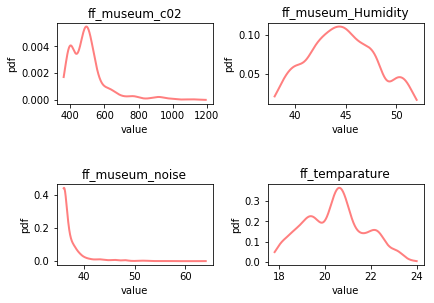

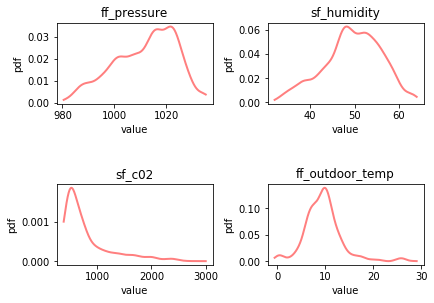

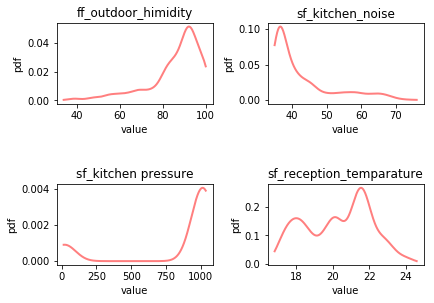

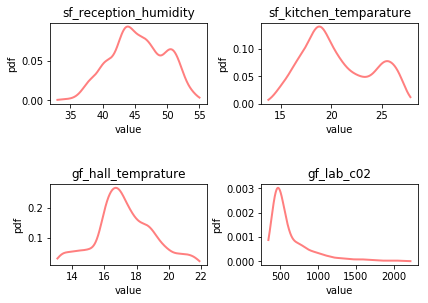

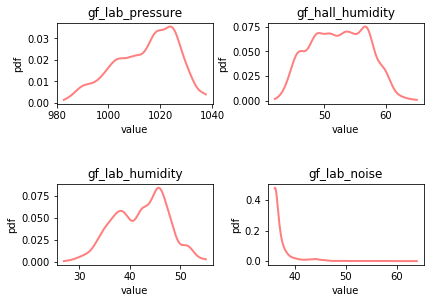

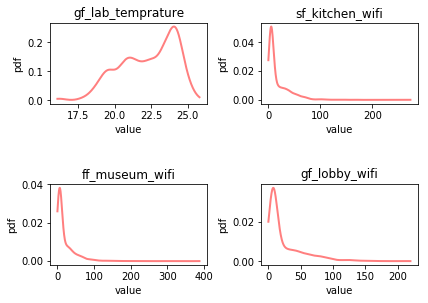

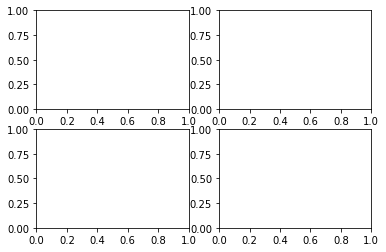

In [0]:
pltno = 0
fig, ax = plt.subplots(2, 2)
for i,column in enumerate(sensors_data.columns):
  if column!='utime':
#     print(column)
    # converts column values to numpy array
    x = sensors_data[column].values
    # The grid we'll use for plotting
    x_grid = np.linspace(x.min(), x.max(), 1000)
    y = kde_scipy(x,x_grid)
    r = int(pltno/2)
    c = int(pltno%2)
    ax[r, c].plot(x_grid, y, color='red', alpha=0.5, lw=2,)# in place of colour = 'r--'
    ax[r, c].set_title(column, y=1)
#     ax[r, c].title.set_position([0.1,1.25])
    ax[r, c].set_xlabel('value')
    ax[r, c].set_ylabel('pdf')
    if pltno == 3:
      plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=1,
                    wspace=0.35)
      plt.show()
      pltno = 0 
      fig, ax = plt.subplots(2, 2)
    else:
      pltno += 1       

### Naive method for identifying the AD - Gaussian Distribution plots for each variable

In [0]:

def kde_scipy(x, x_grid):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x)
    return kde.evaluate(x_grid)

## Kernal Density Estimation in Python
### True_Error_distribution

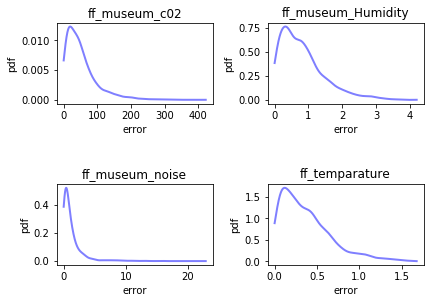

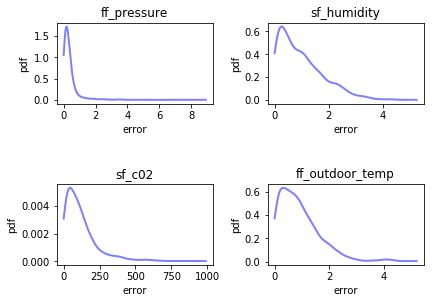

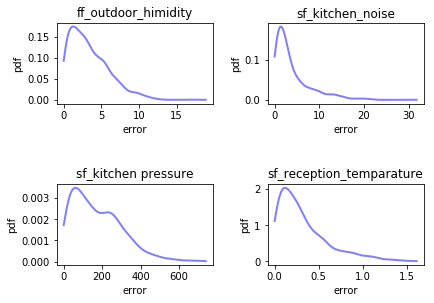

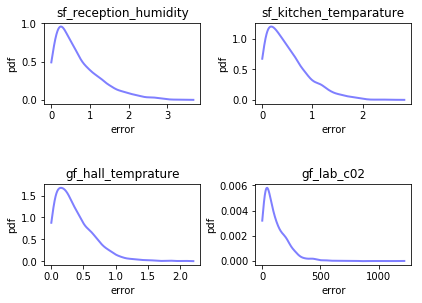

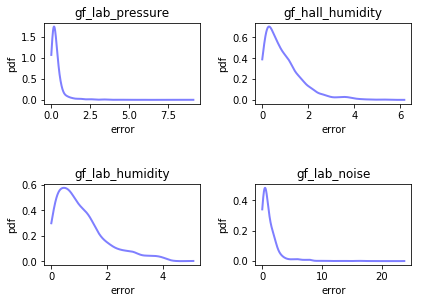

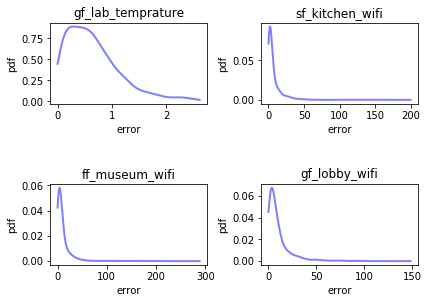

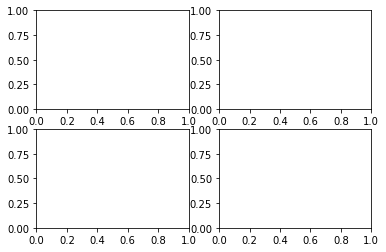

In [0]:
pltno = 0
fig, ax = plt.subplots(2, 2)
for i,column in enumerate(sensors_data.columns):
  if column!='utime':
    
    # converts column values to numpy array
    x = error_dist[column].values
    # The grid we'll use for plotting
    x_grid = np.linspace(x.min(), x.max(), 1000)
    y = kde_scipy(x,x_grid)
    r = int(pltno/2)
    c = int(pltno%2)
    ax[r, c].plot(x_grid, y, color='blue', alpha=0.5, lw=2,)# in place of colour = 'r--'
    ax[r, c].set_title(column, y=1)
#     ax[r, c].title.set_position([0.1,1.25])
    ax[r, c].set_xlabel('error')
    ax[r, c].set_ylabel('pdf')
    if pltno == 3:
      plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=1,
                    wspace=0.35)
      plt.show()
      pltno = 0 
      fig, ax = plt.subplots(2, 2)
    else:
      pltno += 1    

ff_museum_c02


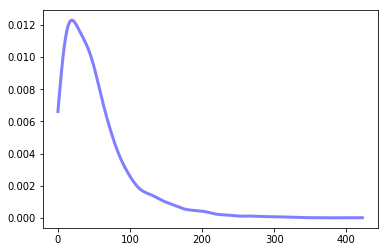

ff_museum_Humidity


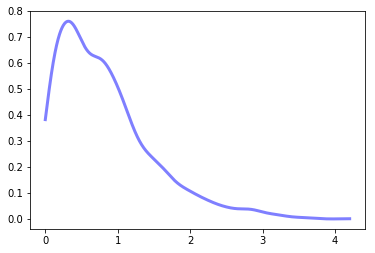

ff_museum_noise


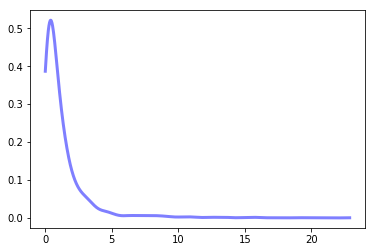

ff_temparature


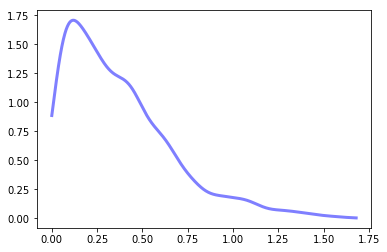

ff_pressure


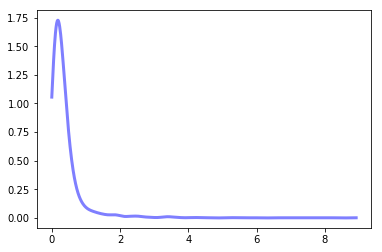

sf_humidity


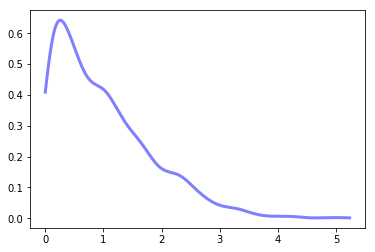

sf_c02


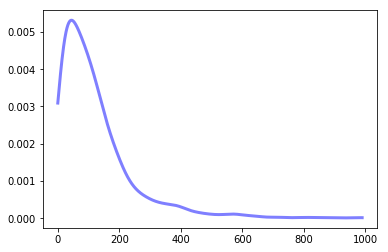

ff_outdoor_temp


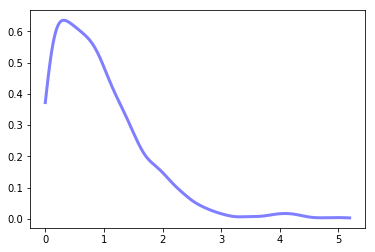

ff_outdoor_himidity


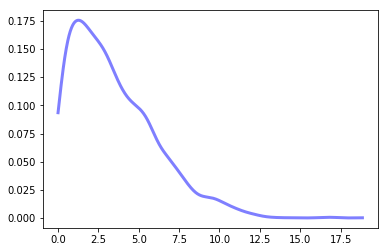

sf_kitchen_noise


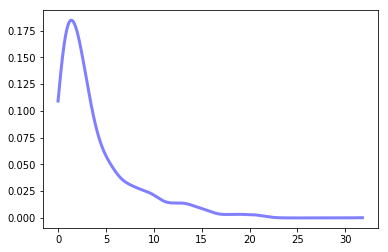

sf_kitchen pressure


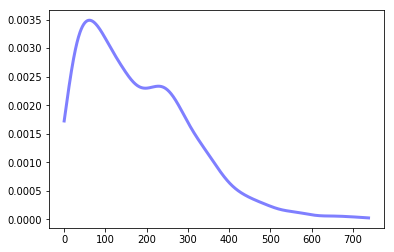

sf_reception_temparature


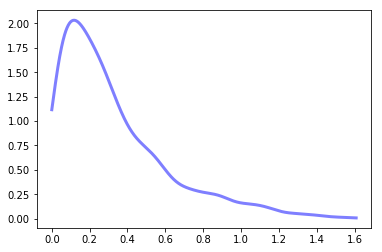

sf_reception_humidity


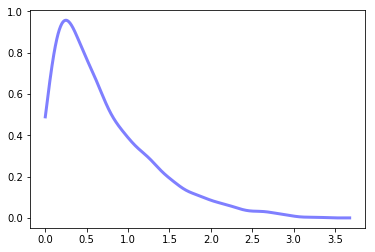

sf_kitchen_temparature


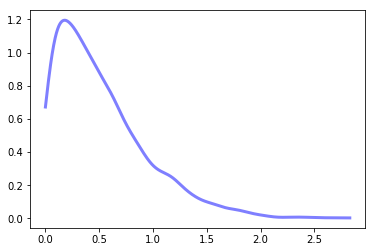

gf_hall_temprature


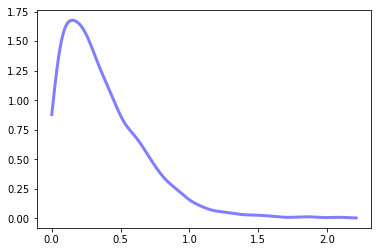

gf_lab_c02


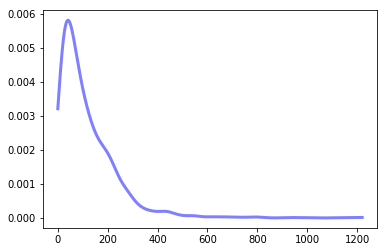

gf_lab_pressure


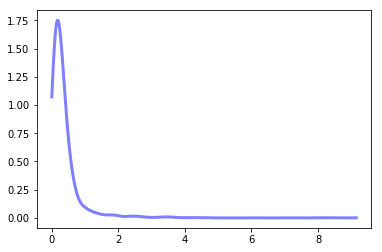

gf_hall_humidity


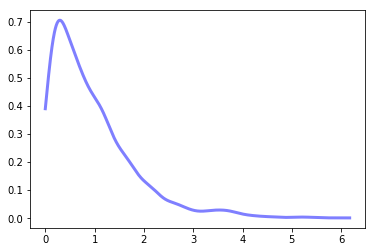

gf_lab_humidity


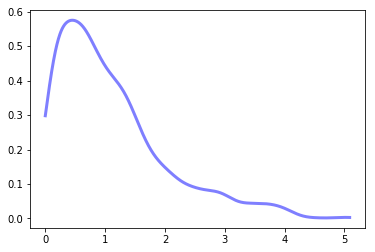

gf_lab_noise


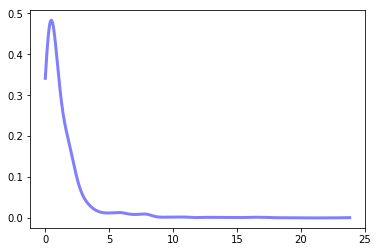

gf_lab_temprature


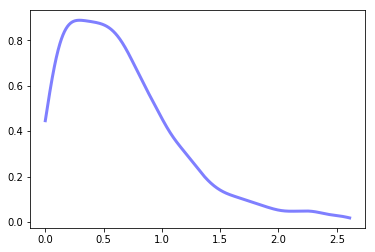

sf_kitchen_wifi


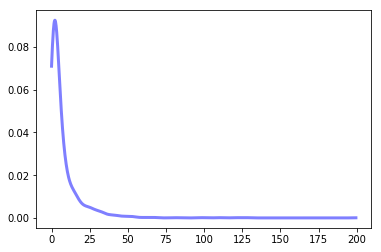

ff_museum_wifi


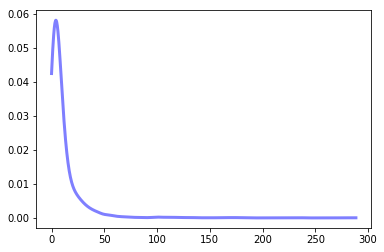

gf_lobby_wifi


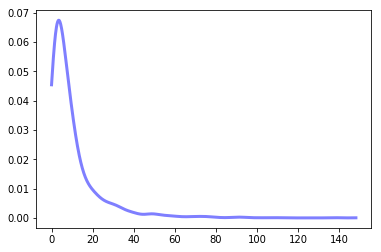

In [0]:
# # error-dist for each sensor
# for i,column in enumerate(sensors_data.columns):
#   if column!='utime':
#     print(column)
#     # converts column values to numpy array
#     x = error_dist[column].values
#     # The grid we'll use for plotting
#     x_grid = np.linspace(x.min(), x.max(), 1000)
#     y = kde_scipy(x,x_grid)
#     plt.plot(x_grid, y, color='blue', alpha=0.5, lw=3)# in place of colour = 'r--'
#     plt.show()    

### Constructing the table
-------------------------------------------------------------------------------------------------
Model# || # Anaomalies || #verified anomalies by atleat2 models (AV2) || AV3 || Model which is mostly verifying(% of confidence) ||


### Mean and Standard Deviation of Sensors

In [0]:
error_dist.keys()

dict_keys(['ff_museum_c02', 'ff_museum_Humidity', 'ff_museum_noise', 'ff_temparature', 'ff_pressure', 'sf_humidity', 'sf_c02', 'ff_outdoor_temp', 'ff_outdoor_himidity', 'sf_kitchen_noise', 'sf_kitchen pressure', 'sf_reception_temparature', 'sf_reception_humidity', 'sf_kitchen_temparature', 'gf_hall_temprature', 'gf_lab_c02', 'gf_lab_pressure', 'gf_hall_humidity', 'gf_lab_humidity', 'gf_lab_noise', 'gf_lab_temprature', 'sf_kitchen_wifi', 'ff_museum_wifi', 'gf_lobby_wifi'])

## Finding the error distrubution parameters - mean and standard dist

In [0]:
alpha = 2
anomaly_threshold = dict()
sensor_means = dict()
sensor_sds =dict()

for column in error_dist.keys():
    sensor_means[column] = error_dist[column].mean()
    sensor_sds[column] = error_dist[column].std()
    anomaly_threshold[column] = sensor_means[column] + alpha * sensor_sds[column]
print(anomaly_threshold)

{'ff_museum_c02': 151.10548259781888, 'ff_museum_Humidity': 2.135762211538347, 'ff_museum_noise': 5.204328921750258, 'ff_temparature': 0.9613912615478949, 'ff_pressure': 1.5729497303590283, 'sf_humidity': 2.6543610059504057, 'sf_c02': 365.46393023139757, 'ff_outdoor_temp': 2.4737981857633224, 'ff_outdoor_himidity': 8.68695790555428, 'sf_kitchen_noise': 12.067303992779689, 'sf_kitchen pressure': 438.92143932511664, 'sf_reception_temparature': 0.897277240670678, 'sf_reception_humidity': 1.8916003163713715, 'sf_kitchen_temparature': 1.3656462094231623, 'gf_hall_temprature': 0.9832343700705464, 'gf_lab_c02': 357.86366590262, 'gf_lab_pressure': 1.5889707227284064, 'gf_hall_humidity': 2.6317685563662407, 'gf_lab_humidity': 2.914534383932161, 'gf_lab_noise': 5.606115481663145, 'gf_lab_temprature': 1.664964532489219, 'sf_kitchen_wifi': 31.09978149299127, 'ff_museum_wifi': 51.72650164957359, 'gf_lobby_wifi': 38.068613153171455}


### Filtering the data using the sensor anomaly Threshold

## Binary Anomaly 

In [0]:
# Filtering anomalies based on each sensor threshold

anomaly_df = pd.DataFrame(columns=model_error.columns)
count = 0

for column in model_error.columns:
  if column != 'utime':
    anomaly_df[column] = (model_error[column]>=anomaly_threshold[column]).astype(int)
    
anomaly_df['utime'] = model_error['utime']   

print(anomaly_df.shape)


(2652, 25)


In [0]:
anomaly_df.head

<bound method NDFrame.head of       ff_museum_c02  ff_museum_Humidity  ...  gf_lobby_wifi       utime
0                 0                   0  ...              0  1902010945
1                 0                   0  ...              0  1902011000
2                 0                   0  ...              0  1902011015
3                 0                   0  ...              0  1902011030
4                 0                   0  ...              0  1902011045
5                 0                   0  ...              0  1902011100
6                 0                   0  ...              0  1902011115
7                 0                   0  ...              0  1902011130
8                 0                   0  ...              0  1902011145
9                 0                   0  ...              0  1902011200
10                0                   0  ...              0  1902011215
11                0                   0  ...              0  1902011230
12                0               

In [0]:
# anomaly_df

resu = anomaly_df.loc[anomaly_df['utime'] == 1903141430]

# anomaly_df.to_csv("anomaly_df.csv")

Empty DataFrame
Columns: [ff_museum_c02, ff_museum_Humidity, ff_museum_noise, ff_temparature, ff_pressure, sf_humidity, sf_c02, ff_outdoor_temp, ff_outdoor_himidity, sf_kitchen_noise, sf_kitchen pressure, sf_reception_temparature, sf_reception_humidity, sf_kitchen_temparature, gf_hall_temprature, gf_lab_c02, gf_lab_pressure, gf_hall_humidity, gf_lab_humidity, gf_lab_noise, gf_lab_temprature, sf_kitchen_wifi, ff_museum_wifi, gf_lobby_wifi, utime]
Index: []


## Timestamp Vs Anomaly Detection(wrt models)

In [0]:
if 'time_sum' in anomaly_df:
  anomaly_df = anomaly_df.drop(['time_sum'], axis=1) 
if 'sensor_sum' in anomaly_df.index:
  anomaly_df = anomaly_df.drop(['sensor_sum']) 

resdf = pd.DataFrame()
resdf['Sensor Name'] = anomaly_df.columns
resdf['Anomaly#1'] = anomaly_df.sum(axis=0).values
anomaly_time_sum = anomaly_df.sum(axis=1)

resdf['Anomaly#2'] = np.zeros(len(anomaly_df.columns))
resdf['Anomaly#3'] = np.zeros(len(anomaly_df.columns))
resdf['Anomaly#4'] = np.zeros(len(anomaly_df.columns))
resdf['Anomaly#5'] = np.zeros(len(anomaly_df.columns))
resdf['Anomaly#6'] = np.zeros(len(anomaly_df.columns))

for i, c in enumerate(anomaly_df.columns):
  dftemp = anomaly_df[anomaly_df[c] == 1].sum(axis=1)
  resdf.loc[i, 'Anomaly#2'] = len(dftemp[dftemp >1])
  resdf.loc[i, 'Anomaly#3'] = len(dftemp[dftemp >2])
  resdf.loc[i, 'Anomaly#4'] = len(dftemp[dftemp >3])
  resdf.loc[i, 'Anomaly#5'] = len(dftemp[dftemp >4])
  resdf.loc[i, 'Anomaly#6'] = len(dftemp[dftemp >5])
  
  
print(resdf)

                 Sensor Name  Anomaly#1  ...  Anomaly#5  Anomaly#6
0              ff_museum_c02      134.0  ...       22.0       14.0
1         ff_museum_Humidity      136.0  ...       20.0       11.0
2            ff_museum_noise       98.0  ...       11.0        4.0
3             ff_temparature      147.0  ...       13.0       10.0
4                ff_pressure       88.0  ...       17.0       12.0
5                sf_humidity      118.0  ...       25.0       17.0
6                     sf_c02      135.0  ...       30.0       20.0
7            ff_outdoor_temp       99.0  ...       17.0       14.0
8        ff_outdoor_himidity      121.0  ...       24.0       16.0
9           sf_kitchen_noise      165.0  ...       21.0       13.0
10       sf_kitchen pressure      104.0  ...        8.0        3.0
11  sf_reception_temparature      154.0  ...       31.0       15.0
12     sf_reception_humidity      138.0  ...       34.0       19.0
13    sf_kitchen_temparature      128.0  ...       36.0       

                 Sensor Name  Anomaly#1  ...  Anomaly#5  Anomaly#6
1         ff_museum_Humidity      136.0  ...       20.0       11.0
2            ff_museum_noise       98.0  ...       11.0        4.0
3             ff_temparature      147.0  ...       13.0       10.0
4                ff_pressure       88.0  ...       17.0       12.0
5                sf_humidity      118.0  ...       25.0       17.0
6                     sf_c02      135.0  ...       30.0       20.0
7            ff_outdoor_temp       99.0  ...       17.0       14.0
8        ff_outdoor_himidity      121.0  ...       24.0       16.0
9           sf_kitchen_noise      165.0  ...       21.0       13.0
10       sf_kitchen pressure      104.0  ...        8.0        3.0
11  sf_reception_temparature      154.0  ...       31.0       15.0
12     sf_reception_humidity      138.0  ...       34.0       19.0
13    sf_kitchen_temparature      128.0  ...       36.0       21.0
14        gf_hall_temprature      108.0  ...       24.0       

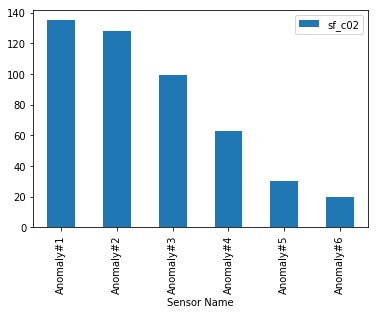

In [0]:
s1 = resdf[1:25]
print(s1)
s1.set_index('Sensor Name', inplace=True)
s1 = s1.transpose()
s1['Sensor Name'] = s1.index
print(s1)

ax = s1.plot.bar(x = 'Sensor Name', y = 'sf_c02',  rot=90)


In [0]:

print(resdf.columns)

Index(['Sensor Name', 'Anomaly#1', 'Anomaly#2', 'Anomaly#3', 'Anomaly#4',
       'Anomaly#5', 'Anomaly#6'],
      dtype='object')


In [0]:
## utime to timepstamp mapping
def get_timestamp(t):  
  ind = Data[Data['utime']==t].index.tolist()
  return Data.iloc[ind]['time'].tolist()[0]


In [0]:
ALERT = anomaly_df[anomaly_df.sum(axis =1)>5]
ALERT = ALERT[['utime']]
# ALERT

modDfObj = ALERT['utime'].apply(lambda t : get_timestamp(t) )
modDfObj=modDfObj.reset_index()
modDfObj.drop(['index'],axis=1)

,utime
0,2019-02-04 12:45:00
1,2019-02-04 13:15:00
2,2019-02-04 13:30:00
3,2019-02-04 14:00:00
4,2019-02-04 14:15:00
5,2019-02-04 14:45:00
6,2019-02-04 15:15:00
7,2019-02-05 10:45:00
8,2019-02-05 11:00:00
9,2019-02-05 11:15:00


In [0]:
# Observe the corelation among the variables - Pearson’s Correlation Coefficient
# (“Correlation does not imply causation”)
# gf humidity 92.5 18
# import pandas as pd
# import numpy as np

# corr = new_data.corr(method='pearson')
# corr.style.background_gradient(cmap='coolwarm').set_precision(2)
# corr.to_csv('corelation.csv')

# Floor wise corelation
# gf_sensors = []
# ff_sensors = []
# sf_sensors = []

# for column in Data.columns:
#   if ("ground" in column or "Ground" in column):
#     gf_sensors.append(column)
#   elif "1st" in column:
#     ff_sensors.append(column)
#   elif "2nd" in column:
#     sf_sensors.append(column)
# Floor wise corealtion - plots

# print(len(gf_sensors),len(ff_sensors),len(sf_sensors))
# df_gf = Data[gf_sensors]
# df_ff = Data[ff_sensors]
# df_sf = Data[sf_sensors]

# # plot floor wise - 8 sensors data

# print(df_gf.shape)
# df_gf = df_gf.join(Data['utime'])
# df_ff = df_ff.join(Data['utime'])
# df_sf = df_sf.join(Data['utime'])

# print(df_gf.shape)

# plot floor wise environment variables
# for column in df_gf.columns:
#   if column != 'utime':
#     print(column)
#     time_x = df_gf['utime']
#     y = df_gf[column] 
#     X = df_gf.drop(column,axis=1)
#     ## fit a model
#     lm = linear_model.LinearRegression()
#     model = lm.fit(X, y)
#     predictions = lm.predict(X)
#     print(predictions[0:5])
#     score = model.score(X, y)
#     print('Score', model.score(X, y))
#     error = abs(y - predictions)
#     data = [df_gf['utime'], df_gf[column], predictions, error]
#     df = pd.DataFrame(df_gf, columns= ['Date','Actual','Predicted','error'])
#     plt.plot(time_x,error,color = 'y')
#     plt.xlabel('Time')
#     plt.ylabel('error_gf')
#     plt.show()
#     plt.savefig(column + '.png')

  
